# 3.1: Weakly non-linear problems - Travel-time tomography #

*Andrew Valentine & Malcolm Sambridge - Research School of Earth Sciences, The Australian National University - Last updated Sept. 2019*

In earlier practicals, we looked at X-ray tomography. Because X-rays propagate at the speed of light, we were able to approximate their paths as straight lines. This mades the inverse problem linear, and relatively straightforward to tackle. However, slower-propagating waves - such as seismic waves in the Earth - have paths that 'bend' when velocity gradients or contrasts are encountered. This property is encapsulated within Snell's Law.

The goal in travel-time tomography is to infer details about the velocity structure of the medium, given measurements of the minimum time taken for a wave to propagate from source to receiver. At first glance, this may seem rather similar to the X-ray tomography problem. However, there is an added complication: as we change our model, the route of the fastest path from source to receiver also changes. Thus, every update we apply to the model will inevitably be (in some sense) based on incorrect assumptions. 

Provided the 'true' velocity structure is not *too* dissimilar from our initial guess, travel-time tomography can be treated as a weakly non-linear problem. On each iteration, we compute ray paths using our current estimate of the velocity model. We then perform a model update treating these paths as fixed. Provided the paths do not change too wildly from iteration to iteration, this procedure will eventually converge towards the true model.

The travel-time of an individual ray can be computed as $$t = \int_\mathrm{path} \frac{1}{v(\mathbf{x})}\,\mathrm{d}\mathbf{x}$$
This points to an additional complication: even for a fixed path, the relationship between velocities and observations is not linear. However, if we define the 'slowness' to be the inverse of velocity, $s(\mathbf{x}) = v^{-1}(\mathbf{x})$, we can write
$$t = \int_\mathrm{path} {s(\mathbf{x})}\,\mathrm{d}\mathbf{x}$$
which *is* linear.

The module `inversionCourse.rayTracer` provides capability for ray-tracing in 2-D discretised velocity models.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from anu_inversion_course import rayTracer as rt

Again, models should be provided in the form of a 2D NumPy array, specify the *velocity* structure. We then must create an instance of the class `rayTracer.gridModel`, passing our model as an argument:

In [2]:
m = np.array([[1,1.1,1.1],
              [1.,1.2,1.4],
              [1.1,1.2,1.3]])
g=rt.gridModel(m)

To access and change the model subsequently, the `rayTracer.gridModel` object provides functions `getVelocity()`, `getSlowness()`, `setVelocity(v)` and `setSlowness(s)`. For example:

In [3]:
mp = g.getVelocity()
mp[1,1] = 1.25
g.setVelocity(mp)
g.getSlowness()

array([[1.        , 0.90909091, 0.90909091],
       [1.        , 0.8       , 0.71428571],
       [0.90909091, 0.83333333, 0.76923077]])

Performing ray-tracing is a two-stage process. First, we 'shoot' rays in all directions from the source, to establish a rough route for the ray-paths. Then we look for the specific path to a particular receiver.

The first task is performed by calling the `shootInitial()` function provided by `rayTracer.gridModel`. This takes a single argument, which is a NumPy array providing the co-ordinates of the source.

In [4]:
src = np.array([0.2,0.25])
g.shootInitial(src)

Now, we call the `findPath()` function, providing the co-ordinates of the receiver. This must be on the surface of the model (which is assumed to occupy the region $0\le x\le1$, $0\le y\le 1$ unless an `extent` argument is provided when initialising `rayTracer.gridModel`)

In [5]:
rec1 = np.array([0.8,1])
travelTimes1, paths1, sensitivities1 = g.findPath(rec1)

This returns three lists: often these will only contain a single element, but in more complex models it is possible for more than one path to exist between source and receiver. The first list contains the travel-times along each path; the second contains the $(x,y)$ coordinates describing the path taken; and the third contains the $\mathbf{G}$ matrix describing the path-length in each model cell.

We can call `findPath()` multiple times for different receivers. It is only necessary to call `shootInitial()` again if the source location changes.

The function `rayTracer.displayModel()` allows us to plot the model, and (optionally) the paths. The syntax is almost identical to the `xrayTomography` version.

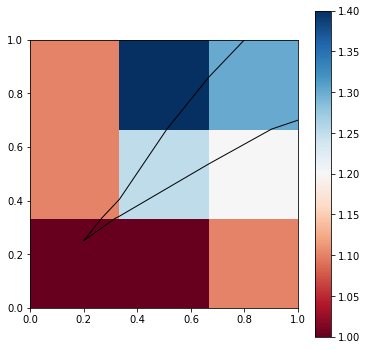

In [6]:
rec2 = np.array([1,0.7])
travelTimes2, paths2, sensitivities2 = g.findPath(rec2)
# Join the lists containing path information:
allPaths = paths1 + paths2
rt.displayModel(g.getVelocity(),allPaths,cmap=plt.cm.RdBu)


Let's try a different source-receiver configuration.

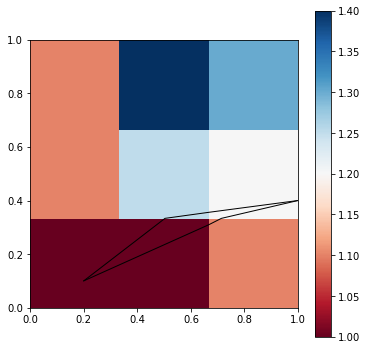

In [7]:
src = np.array([0.2,0.1])
g.shootInitial(src)
rec1 = np.array([0.8,1])
travelTimes1, paths1, sensitivities1 = g.findPath(rec1)
rec2 = np.array([1,0.4])
travelTimes2, paths2, sensitivities2 = g.findPath(rec2)
allPaths = paths1 + paths2
rt.displayModel(g.getVelocity(),allPaths,cmap=plt.cm.RdBu)

In this case, the ray-tracer has been unable to find any path from the source to the first receiver (`len(path1)` is 0), but it has found two alternative routes to the second receiver (`len(path2)` is 2). The strong velocity contrasts in this model lead to some interesting ray geometries, as we can see by using `rayTracer.generateSurfacePoints()` to generate stations all around the region (as in the X-ray tomography example):

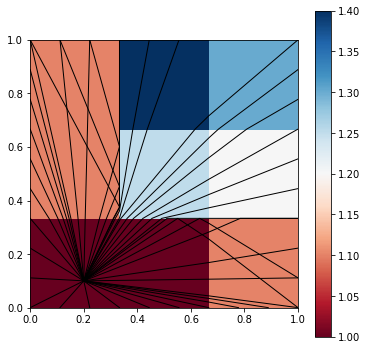

In [8]:
recs = rt.generateSurfacePoints(8)
paths = []
for r in recs:
    t,p,A = g.findPath(r)
    paths+=p
rt.displayModel(g.getVelocity(),paths)

We see there is a 'shadow zone' in the upper right of the model region, where no paths can be found. This is a physically-reasonable effect, but it is worth noting that the ray-tracer is not perfect, and may fail to find paths that nevertheless exist. This issue is an unavoidable problem in computational work.

From the perspective of performing travel-time tomography, we will assume we can only measure the *first* arrival at each receiver. Thus, if multiple paths are found, we will select the shortest (fastest) and work with this. To simplify the process, `rayTomography.gridModel` provides a `tracer()` function which is designed to compute first arrivals from many sources at many receivers. It returns an array of first-arrival times (a value '0' indicates that no valid path could be found) and a sensitivity matrix. The ordering of data in these comes from an internal loop of the form
```python
i=0
for s in src:
    for r in rec:
        [...]
        ttimes[i],A[i,:] = ...
        i+=1
return ttimes,A
```
In other words, given $N_{srcs}$ sources and $N_{recs}$ receivers, the first $N_{recs}$ elements of `ttimes` will correspond to the first source; the next $N_{recs}$ elements will correspond to the second source; and so forth.

In [9]:
srcs = np.array([[0.2,0,1],[0.7,0.4]])
ttimes, A = g.tracer(srcs,recs)

/var/folders/4n/0gmvb0nd687053z9vz_2x4g40000gp/T/ipykernel_77198/3133031798.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  srcs = np.array([[0.2,0,1],[0.7,0.4]])
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 88.44it/s]


It may be useful to visualise the average sensitivity of a measurement to the various model parameters, for example:

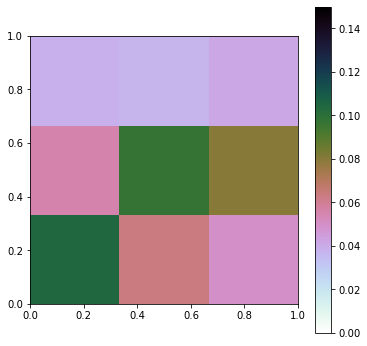

In [10]:
rt.displayModel(A.mean(0).reshape(3,3),cmap=plt.cm.cubehelix_r,clim=(0,0.15))

**Task 1:** Familiarise yourself with the ray-tracing routines.

In [11]:
# Try it here! You can insert more cells by selecting Cell > Insert Cell Above/Below from the menu
# bar, or by pressing Esc to enter command mode and then hitting A or B (for above/below). 



The directory `ttimes` contains three files: `sources.dat`, `receivers.dat`, and `ttimes.dat`. The first two have three columns: an index, an x-location, and a y-location. The third also has three columns, but with different meaning: the first is the source index, the second is the receiver index, and the third is the source-receiver travel time. Thus, if you have done:
```python
sourcedat=np.loadtxt('Datasets/ttimes/sources.dat')
recdat = np.loadtxt('Datasets/ttimes/receivers.dat')
ttdat = np.loadtxt('Datasets/ttimes/ttimes.dat')
```
then `ttdat[i,2]` is the travel-time from the source at `sourcedat[int(ttdat[i,0]),1:]` to the receiver at `recdat[int(ttdat[i,0]),1:]`.

***Note that some receivers may not have recorded data for every event!***

**Task 2:** Set up and perform an iterative tomographic inversion for this dataset. You can assume a prior velocity model
```python
m0 = 40.5*np.ones([30,30])
```

*Hint: Remember to distinguish between slowness and velocity!*

In [12]:
# Try it here! You can insert more cells by selecting Cell > Insert Cell Above/Below from the menu
# bar, or by pressing Esc to enter command mode and then hitting A or B (for above/below). 



**Task 3:** Explore how your results are affected by:
- Regularisation/the choice of prior model
- The dimension of the model you seek to recover

In [13]:
# Try it here! You can insert more cells by selecting Cell > Insert Cell Above/Below from the menu
# bar, or by pressing Esc to enter command mode and then hitting A or B (for above/below). 



If you want to experiment further, you can use the function `rayTracer.pngToModel(filename,nx,ny,bg,sc)` to create models from `.png` files. The `bg` option is used to set the background velocity in the model: the larger `bg`, the more linear you can expect the ray-tracing to be. `sc` rescales all values; small `sc` implies longer average travel-times.

In [14]:
# Try it here! You can insert more cells by selecting Cell > Insert Cell Above/Below from the menu
# bar, or by pressing Esc to enter command mode and then hitting A or B (for above/below). 


----